# Module Imports
Import required packages

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from ast import literal_eval
from skmultilearn.model_selection import iterative_train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

2024-09-25 18:08:56.048865: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 18:08:57.966158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Runtime Config
Set runtime configuration options

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def set_memory_growth():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

def set_memory_limit(memory_limit):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=memory_limit)]
        )

    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

HOME = os.environ['HOME']
LOCAL = True if "ruairi" in HOME else False

if LOCAL:
    set_memory_limit(4096)
    #set_memory_growth()
    keras.mixed_precision.set_global_policy("mixed_float16")
else:
    from google.colab import drive
    drive.mount('/content/drive')

pd.set_option('display.max_columns', None)

1 Physical GPU, 1 Logical GPUs


2024-09-25 18:09:03.593154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-25 18:09:03.893850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-25 18:09:03.893965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-25 18:09:03.898907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-25 18:09:03.899019: I external/local_xla/xla/stream_executor

# Unfiltered vs Filtered
Loads the results of Experiment 1 comparing the performance of MobileNetV2 when using the stratified vs unstratified datasets.

In [4]:
df = pd.read_csv("../model_metrics/model_metrics.csv")
df = df[df.model.str.contains("mobilenet")]
df = df.sort_values(by="test_loss", ascending=True).set_index("model").T
f1 = df.loc[[i for i in df.index if "per_class" in i]]
df = df.drop(f1.index)
df

model,mobilenet_softmax_unfiltered,mobilenet_softmax
categorical_accuracy,0.913434,0.916121
f1_score_weighted,0.908688,0.910456
loss,0.29668,0.275836
val_categorical_accuracy,0.829457,0.819417
val_f1_score_weighted,0.806863,0.805573
val_loss,0.621748,0.604919
type,CLF,CLF
epoch,10,11
test_loss,0.57495,0.674329
test_categorical_accuracy,0.823643,0.784047


# Binary vs Softmax
- Loads the results of Experiment 2, comparing the use of multi-label (binary) methodology to multi-class (softmax).
- Separates models into their multi-class and multi-label dataframes

In [6]:
df_softmax = pd.read_csv("../model_metrics/model_metrics.csv")
df_softmax = df_softmax[["model", "epoch", "type", "loss", "categorical_accuracy", "f1_score_weighted", "f1_score_per_class", "val_loss", "val_categorical_accuracy", "val_f1_score_weighted", "val_f1_score_per_class", "test_loss", "test_categorical_accuracy", "test_f1_score_weighted", "test_f1_score_per_class"]]
df_softmax = df_softmax.sort_values(by="test_loss", ascending=True)
df_softmax = df_softmax[~df_softmax.model.str.contains("unfiltered")]

In [7]:
df_softmax

,model,epoch,type,loss,categorical_accuracy,f1_score_weighted,f1_score_per_class,val_loss,val_categorical_accuracy,val_f1_score_weighted,val_f1_score_per_class,test_loss,test_categorical_accuracy,test_f1_score_weighted,test_f1_score_per_class
2,vgg16_softmax,16,FT,0.121801,0.965818,0.961830,"tf.Tensor(\n[0.9729729 0.9266666 0.9437652 0.9854903 0.9230769 0.98916954\n 0.9268293 1. 0.8717948 0.92857134 0.9090909 1.\n 0.9473683 0.96928316 1. 1. 1. 0.9918367\n 0.98070365 0.9599999 0.9960681 0.9022556 0.60975605 1.\n 0.92452824], shape=(25,), dtype=float32)",0.689990,0.850485,0.830488,"tf.Tensor(\n[0. 0.45161283 0.6222221 0.9058295 0.49999994 0.9090909\n 0.79999995 0.33333328 0.4285714 0.9999998 0.39999995 0.9999998\n 0.66666657 0.9729729 0.8235293 0. 0.66666657 0.9538461\n 0.9344978 0.6666666 0.9071038 0.86075944 0.24999997 0.\n 0.8235293 ], shape=(25,), dtype=float32)",0.594273,0.856031,0.836062,"[0.0, 0.66666657, 0.76595736, 0.9266054, 0.52173907, 0.96969694, 0.22222218, 0.79999995, 0.28571424, 0.6666666, 0.6666666, 0.9999998, 0.9999998, 0.7333333, 0.9, 0.9999998, 0.9999998, 0.9032257, 0.9210525, 0.6666666, 0.91620106, 0.868421, 0.0, 0.0, 0.6666666]"
3,inceptionv3_softmax,21,FT,0.183632,0.951030,0.948215,"tf.Tensor(\n[0.9714285 0.9127516 0.94660187 0.97566617 0.9298245 0.96727264\n 0.9523809 0.97872335 0.8461538 0.88888884 0.9090909 1.\n 0.8 0.94845355 0.97530854 1. 1. 0.94308937\n 0.95823926 0.9315068 0.99540377 0.88888884 0.6181817 1.\n 0.9259259 ], shape=(25,), dtype=float32)",0.600274,0.836257,0.818138,"tf.Tensor(\n[0. 0.56410253 0.7346938 0.9308756 0.4615384 0.8333334\n 0.33333328 1. 0.4705882 0. 0.6666666 0.9999998\n 0.66666657 0.7428571 0.8695651 0. 0.9999998 0.89285713\n 0.8831168 0.6666666 0.91111106 0.82926816 0. 0.\n 0.79999995], shape=(25,), dtype=float32)",0.607047,0.866279,0.853657,"[0.49999994, 0.48648643, 0.8163265, 0.9541284, 0.58823526, 0.8648648, 0.57142854, 1.0, 0.5555555, 0.79999995, 0.6666666, 0.9999998, 0.9999998, 0.8484848, 1.0, 0.9999998, 0.66666657, 0.8771929, 0.91891885, 0.59999996, 0.91891885, 0.86075944, 0.35294113, 0.0, 0.54545444]"
4,inceptionresnetv2_softmax,31,FT,0.140608,0.965576,0.960688,"tf.Tensor(\n[1. 0.8949152 0.9491525 0.9750724 0.90598285 0.98901093\n 1. 1. 0.87741935 0.87999994 0.95522386 1.\n 1. 0.9757785 0.99393934 1. 1. 0.99389\n 0.9802594 0.9729729 1. 0.911111 0.57861626 1.\n 0.96153843], shape=(25,), dtype=float32)",0.486906,0.870155,0.853047,"tf.Tensor(\n[0. 0.61111104 0.7777777 0.93896705 0.8235293 0.9411764\n 0.39999995 0.79999995 0.4705882 0.6666666 0.74999994 0.9999998\n 0.9999998 0.88888884 1. 0.9999998 0.9999998 0.8965516\n 0.9350649 0.5714285 0.9130434 0.85333323 0.13333333 0.\n 0.625 ], shape=(25,), dtype=float32)",0.634418,0.855751,0.834905,"[0.0, 0.45161283, 0.79999995, 0.91479814, 0.39999992, 0.9411764, 0.66666657, 0.0, 0.59999996, 0.49999997, 0.49999994, 0.9999998, 1.0, 0.7222221, 0.85714275, 0.0, 0.66666657, 0.9122806, 0.9115044, 0.7272727, 0.92896163, 0.88607585, 0.24999997, 0.0, 0.7272727]"
1,mobilenet_softmax,11,CLF,0.275836,0.916121,0.910456,"tf.Tensor(\n[0.94444436 0.72597855 0.82793015 0.9343232 0.85964906 0.87452465\n 0.9767441 0.97872335 0.7814568 0.92857134 0.86666656 1.\n 1. 0.92579496 0.9575757 0.8 1. 0.96945006\n 0.94602114 0.9599999 0.9782751 0.85191953 0.48101264 0.8888889\n 0.89719623], shape=(25,), dtype=float32)",0.604919,0.819417,0.805573,"tf.Tensor(\n[0. 0.5 0.70588225 0.9223744 0.54545444 0.8484848\n 0.39999995 1. 0.631579 0.66666657 0.74999994 0.\n 0.9999998 0.74999994 1. 0. 0.66666657 0.83333325\n 0.85836905 0.8 0.89729726 0.7142857 0.16666663 0.\n 0.7272727 ], shape=(25,), dtype=float32)",0.674329,0.784047,0.780987,"[0.0, 0.53658533, 0.76595736, 0.8928571, 0.19999996, 0.7428571, 0.0, 0.49999997, 0.37499994, 0.9999998, 0.74999994, 0.9999998, 1.0, 0.74999994, 0.8181817, 0.0, 0.9999998, 0.83018863, 0.8559321, 0.49999994, 0.88043475, 0.66666657, 0.49999994, 0.0, 0.4615384]"


In [8]:
df_binary = pd.read_csv("../model_metrics/model_metrics_binary.csv")
df_binary = df_binary[["model", "epoch", "type", "loss", "binary_accuracy", "f1_score_weighted", "f1_score_per_class", "val_loss", "val_binary_accuracy", "val_f1_score_weighted", "val_f1_score_per_class", "test_loss", "test_binary_accuracy", "test_f1_score_weighted", "test_f1_score_per_class"]]
df_binary = df_binary.sort_values(by="test_loss", ascending=True)
df_binary.head()

,model,epoch,type,loss,binary_accuracy,f1_score_weighted,f1_score_per_class,val_loss,val_binary_accuracy,val_f1_score_weighted,val_f1_score_per_class,test_loss,test_binary_accuracy,test_f1_score_weighted,test_f1_score_per_class
0,mobilenet_binary,12,FT,0.033339,0.986889,0.832202,"tf.Tensor(\n[0.51851845 0.62121207 0.69720095 0.8859293 0.59405935 0.73092365\n 0.55555546 0.8181817 0.6174496 0.72727275 0.64 0.49999997\n 0.8888889 0.7857142 0.8227847 0.8888889 0.81818175 0.89938396\n 0.85714275 0.8405797 0.9491749 0.82901555 0.5673076 0.3076923\n 0.7789473 ], shape=(25,), dtype=float32)",0.045127,0.984758,0.765038,"tf.Tensor(\n[0. 0.30769226 0.6956521 0.9107142 0.49999994 0.8823529\n 0.39999995 0. 0.4285714 0.66666657 0.39999995 0.\n 0.9999998 0.4347826 0.9523809 0. 0.66666657 0.91803277\n 0.8679245 0. 0.8913043 0.7540983 0. 0.\n 0.39999995], shape=(25,), dtype=float32)",0.041557,0.984844,0.774099,"[0.0, 0.38461536, 0.5641025, 0.9115044, 0.49999994, 0.81249994, 0.39999995, 0.79999995, 0.26666662, 0.9999998, 0.6666666, 0.0, 0.0, 0.79999995, 0.8999999, 0.0, 0.9999998, 0.892857, 0.8348623, 0.0, 0.8924731, 0.74576265, 0.24999997, 0.0, 0.6666666]"
2,inceptionv3_binary,22,FT,0.011501,0.996120,0.952604,"tf.Tensor(\n[0.7647058 0.87248313 0.9349397 0.9594907 0.8571428 0.967509\n 0.8571428 1. 0.88343555 0.92307687 0.85245895 0.9090909\n 1. 0.9103448 0.9759036 1. 0.96 0.98770493\n 0.9667978 0.90410954 0.98621136 0.9479166 0.85201794 0.8888889\n 0.94230765], shape=(25,), dtype=float32)",0.047363,0.985892,0.806787,"tf.Tensor(\n[0. 0.5714285 0.7826087 0.92857134 0.5333333 0.8484848\n 0.39999995 0.49999997 0.15384611 0.6666666 0.39999995 0.9999998\n 0.9999998 0.74999994 0.8888889 0. 0.9999998 0.8965516\n 0.9106383 0.3636363 0.8024691 0.8461538 0.39999998 0.\n 0.72727275], shape=(25,), dtype=float32)",0.044081,0.986667,0.809430,"[0.0, 0.60606056, 0.6666666, 0.9209302, 0.74999994, 0.93749994, 0.49999997, 0.79999995, 0.4285714, 0.66666657, 0.0, 0.0, 1.0, 0.56, 0.9523809, 0.0, 0.66666657, 0.8727272, 0.8908297, 0.79999995, 0.8639052, 0.90410954, 0.19047615, 0.0, 0.49999997]"
1,vgg16_binary,4,CLF,0.019290,0.992891,0.910056,"tf.Tensor(\n[0.30769226 0.7789473 0.8195121 0.95078164 0.7090909 0.9090908\n 0.57142854 0.9565217 0.7225806 0.69230765 0.8275861 0.44444442\n 0.9473683 0.87499994 0.93975896 1. 0.96 0.96326524\n 0.9434389 0.8888889 0.9662921 0.93402773 0.726415 0.49999994\n 0.7524752 ], shape=(25,), dtype=float32)",0.044372,0.983236,0.789391,"tf.Tensor(\n[0. 0.5142857 0.7407407 0.9004739 0.5454545 0.8333334\n 0. 0.6666666 0.55999994 0. 0.39999995 0.9999998\n 0.66666657 0.6060605 0.9166666 0. 0.9999998 0.8999999\n 0.83653843 0.6153846 0.8622754 0.77647054 0.33333328 0.\n 0.6086956 ], shape=(25,), dtype=float32)",0.049901,0.983178,0.789475,"[0.0, 0.59459454, 0.6530612, 0.9107142, 0.24999997, 0.7567567, 0.2857142, 0.5714285, 0.631579, 1.0, 0.5714285, 0.9999998, 0.9999998, 0.49999994, 0.9473683, 0.9999998, 0.66666657, 0.8727272, 0.88288283, 0.6666666, 0.81212115, 0.7586207, 0.59999996, 0.0, 0.5454545]"
3,inceptionresnetv2_binary,35,FT,0.008328,0.997080,0.964262,"tf.Tensor(\n[0.88235295 0.85618716 0.9016786 0.9727535 0.8623853 0.97435886\n 0.9756097 1. 0.8902439 0.92307687 0.9253731 0.9090909\n 1. 0.96928316 0.98795176 1. 1. 0.98775506\n 0.97857946 0.94594586 0.9907894 0.9756097 0.9 0.9473683\n 0.9333332 ], shape=(25,), dtype=float32)",0.038758,0.986951,0.820150,"tf.Tensor(\n[0. 0.53333324 0.74999994 0.9272726 0.49999994 0.8823529\n 0.79999995 0.8571428 0.59999996 0.66666657 0. 0.9999998\n 0.9999998 0.82352936 0.9523809 0. 0.66666657 0.9090908\n 0.8282827 0.44444442 0.90173405 0.88888884 0.26086953 0.\n 0.76923066], shape=(25,), dtype=float32)",0.052088,0.984747,0.796656,"[0.0, 0.36363626, 0.711111, 0.89908254, 0.7142857, 0.9090909, 0.39999995, 0.79999995, 0.6666666, 0.66666657, 0.6666666, 0.9999998, 1.0, 0.83333325, 0.8421052, 0.9999998, 0.9999998, 0.83333325, 0.85990334, 0.5714285, 0.84393054, 0.79411757, 0.23999996, 0.0, 0.54545444]"


### Combine Dataframes
Dataframes are combined to display the test results for each methodology for each model.

In [9]:
df_binary2 = df_binary
df_binary2.columns = [col.replace("binary_", "") for col in df_binary2.columns]

df_softmax2 = df_softmax
df_softmax2.columns = [col.replace("categorical_", "") for col in df_softmax2.columns]

In [10]:
df = pd.concat([df_softmax2, df_binary2])
df = df[["model", "test_loss", "test_accuracy", "test_f1_score_weighted"]]
df["model_name"] = df.model.apply(lambda x: x.split("_")[0])
df["task"] = df.model.apply(lambda x: "multilabel" if "binary" in x else "muticlass")

df2 = df.set_index(["model_name", "task"]).drop(columns=["model"]).sort_values(by="model_name")
df2.test_accuracy = np.round(df2.test_accuracy * 100, 2).astype(str) + "%"
df2.test_f1_score_weighted = np.round(df2.test_f1_score_weighted * 100, 2).astype(str) + "%"
df2

test_loss test_accuracy test_f1_score_weighted
model_name        task                                                      
inceptionresnetv2 muticlass    0.634418        85.58%                 83.49%
                  multilabel   0.052088        98.47%                 79.67%
inceptionv3       muticlass    0.607047        86.63%                 85.37%
                  multilabel   0.044081        98.67%                 80.94%
mobilenet         muticlass    0.674329         78.4%                  78.1%
                  multilabel   0.041557        98.48%                 77.41%
vgg16             muticlass    0.594273         85.6%                 83.61%
                  multilabel   0.049901        98.32%                 78.95%

# Top Performers
- The results of Experiment 3 are displayed, showing the models in order of best performance for the three metrics, loss, accuracy and f1 score.
- The loss is showen in ascending order, as a lower loss is better.
- Accuracy and F1 score are shown in descending order, as a higher result is better.

In [11]:
df_loss = df[["model", "test_loss"]].sort_values(by="test_loss", ascending=True).rename(columns={"model":"model_loss"}).reset_index(drop=True)
df_acc = df[["model", "test_accuracy"]].sort_values(by="test_accuracy", ascending=False).rename(columns={"model":"model_accuracy"}).reset_index(drop=True)
df_f1_score = df[["model", "test_f1_score_weighted"]].sort_values(by="test_f1_score_weighted", ascending=False).rename(columns={"model":"model_f1_score"}).reset_index(drop=True)

In [12]:
top = pd.concat([df_loss, df_acc, df_f1_score], axis=1)
top.test_accuracy = np.round(top.test_accuracy * 100, 2).astype(str) + "%"
top.test_f1_score_weighted = np.round(top.test_f1_score_weighted * 100, 2).astype(str) + "%"
top = top.replace("_binary", "_multilabel", regex=True)
top = top.replace("_softmax", "_multiclass", regex=True)
top.test_loss = np.round(top.test_loss, 4)
top.columns = [c.replace("test_", "") for c in top.columns]
top

,model_loss,loss,model_accuracy,accuracy,model_f1_score,f1_score_weighted
0,mobilenet_multilabel,0.0416,inceptionv3_multilabel,98.67%,inceptionv3_multiclass,85.37%
1,inceptionv3_multilabel,0.0441,mobilenet_multilabel,98.48%,vgg16_multiclass,83.61%
2,vgg16_multilabel,0.0499,inceptionresnetv2_multilabel,98.47%,inceptionresnetv2_multiclass,83.49%
3,inceptionresnetv2_multilabel,0.0521,vgg16_multilabel,98.32%,inceptionv3_multilabel,80.94%
4,vgg16_multiclass,0.5943,inceptionv3_multiclass,86.63%,inceptionresnetv2_multilabel,79.67%
5,inceptionv3_multiclass,0.6070,vgg16_multiclass,85.6%,vgg16_multilabel,78.95%
6,inceptionresnetv2_multiclass,0.6344,inceptionresnetv2_multiclass,85.58%,mobilenet_multiclass,78.1%
7,mobilenet_multiclass,0.6743,mobilenet_multiclass,78.4%,mobilenet_multilabel,77.41%


***
***
***
***
***

# Visualise
The training history for the best model/metrhodology combination is displayed, with a vertical line to indicate the best epoch number.

In [15]:
best_val_loss_model = top.iloc[0, :].model_loss
best_val_loss_model

'mobilenet_multilabel'

In [17]:
df = pd.read_csv("../histories/mobilenet_binary.csv")
df.head()

,binary_accuracy,f1_score_per_class,f1_score_weighted,loss,val_binary_accuracy,val_f1_score_per_class,val_f1_score_weighted,val_loss,type,epoch
0,0.966536,"tf.Tensor(\n[0. 0.04705881 0.2785714 0.7059552 0. 0.02352938\n 0. 0.05405401 0.03478257 0. 0. 0.\n 0. 0.13953485 0.05454541 0. 0. 0.373259\n 0.5977142 0.15094337 0.8418156 0.2835051 0.04545452 0.\n 0.02150533], shape=(25,), dtype=float32)",0.482657,0.099884,0.974623,"tf.Tensor(\n[0. 0.09999999 0.42105258 0.8059701 0. 0.29999995\n 0. 0. 0.33333328 0. 0. 0.\n 0. 0.36363634 0.16666666 0. 0. 0.62745094\n 0.72566366 0. 0.7826086 0.52777773 0. 0.\n 0. ], shape=(25,), dtype=float32)",0.579240,0.074405,CLF,0
1,0.978123,"tf.Tensor(\n[0. 0.29523802 0.56179774 0.8156955 0.03333333 0.26666662\n 0.09090907 0.2222222 0.29357794 0.13333333 0.11428571 0.\n 0. 0.53881276 0.46846843 0. 0. 0.7325301\n 0.7138842 0.56140345 0.91749173 0.70799994 0.28205124 0.\n 0.10526314], shape=(25,), dtype=float32)",0.663017,0.058384,0.976093,"tf.Tensor(\n[0. 0.18181814 0.4736842 0.86407757 0.2222222 0.5217391\n 0. 0. 0.3076923 0. 0.39999995 0.\n 0. 0.49999997 0.5714285 0. 0.66666657 0.6530612\n 0.65306115 0. 0.795031 0.55384606 0.09523804 0.\n 0.28571427], shape=(25,), dtype=float32)",0.620814,0.063787,CLF,1
2,0.981469,"tf.Tensor(\n[0. 0.40552992 0.6089385 0.844133 0.23188402 0.3957219\n 0.15999997 0.48484844 0.4193548 0.44444442 0.24999999 0.\n 0.46153846 0.6666666 0.6461538 0. 0.4705882 0.805492\n 0.75788283 0.7692307 0.92909205 0.7888888 0.5108695 0.\n 0.5333333 ], shape=(25,), dtype=float32)",0.732587,0.048124,0.978027,"tf.Tensor(\n[0. 0.19047618 0.4736842 0.8771929 0.39999998 0.58333325\n 0. 1. 0.18181816 0. 0.39999995 0.\n 0. 0.49999997 0.4285714 0. 0.66666657 0.77777773\n 0.7560975 0. 0.81707305 0.6829268 0.29629627 0.\n 0.28571427], shape=(25,), dtype=float32)",0.675066,0.059877,CLF,2
3,0.983176,"tf.Tensor(\n[0. 0.40528628 0.6576819 0.8553016 0.32432428 0.54081625\n 0.5333333 0.73684204 0.5373134 0.6666666 0.4444444 0.49999997\n 0.8235293 0.6938775 0.64705884 0. 0.5555555 0.83700436\n 0.7825112 0.8115942 0.93899196 0.7999999 0.5549738 0.18181816\n 0.53164554], shape=(25,), dtype=float32)",0.765104,0.042315,0.978801,"tf.Tensor(\n[0. 0.18181814 0.5128205 0.8727272 0.33333328 0.64\n 0. 0.79999995 0.39999995 0.66666657 0.39999995 0.\n 0.9999998 0.56 0.631579 0. 0.66666657 0.77777773\n 0.7106598 0. 0.8554913 0.63888884 0.09523804 0.\n 0.44444442], shape=(25,), dtype=float32)",0.681086,0.055052,CLF,3
4,0.984824,"tf.Tensor(\n[0.36363634 0.45614034 0.68279564 0.8613395 0.45569614 0.58823526\n 0.62499994 0.7804878 0.532374 0.7826087 0.6153846 0.28571427\n 0.8235293 0.7199999 0.70588225 0.33333328 0.7619048 0.8817204\n 0.8088485 0.8285714 0.9459102 0.82504594 0.5685278 0.18181816\n 0.61176467], shape=(25,), dtype=float32)",0.791760,0.038156,0.980271,"tf.Tensor(\n[0. 0.3703703 0.6190476 0.87610614 0.30769226 0.64\n 0. 0.79999995 0.4285714 0. 0.39999995 0.\n 0.9999998 0.56 0.6999999 0. 0.66666657 0.77777773\n 0.8141593 0.33333328 0.8433734 0.6666666 0.09523804 0.\n 0.44444442], shape=(25,), dtype=float32)",0.716507,0.053279,CLF,4


In [18]:
best_epoch = df[df.val_loss == df.val_loss.min()]
best_epoch_num = best_epoch.epoch.values[0]

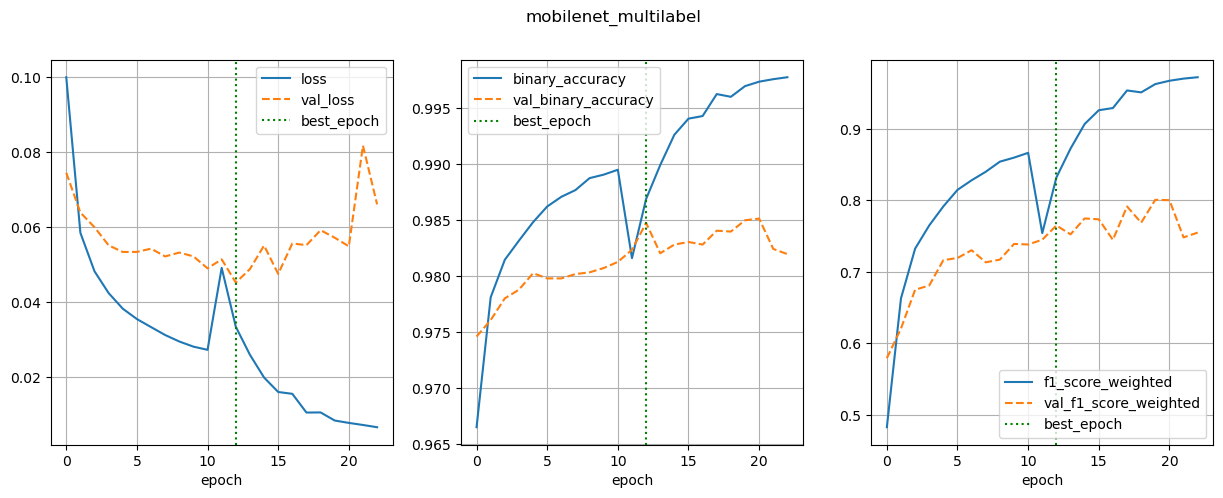

In [19]:
axes = df.plot(
    layout=(1,3),
    x="epoch",
    y= ["loss", "val_loss", "binary_accuracy", "val_binary_accuracy", "f1_score_weighted", "val_f1_score_weighted"],
    subplots=[("loss", "val_loss"), ("binary_accuracy", "val_binary_accuracy"), ("f1_score_weighted", "val_f1_score_weighted")],
    grid=True,
    figsize=(15,5),
    colormap=ListedColormap(["tab:blue", "tab:orange"]*3),
    style=["-", "--"]*3,
    title=best_val_loss_model
)
for ax in axes.flatten():
    ax.axvline(best_epoch_num, c="green", linestyle=":", label="best_epoch")
    ax.legend()